# Machine Learning Foundation

## Course 3, Part a: Logistic Regression


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration 
- Triaxial Angular velocity from the gyroscope 
- A 561-feature vector with time and frequency domain variables 
- The activity label 

More information about the features are available on the website linked above.


Install the below libraries


In [1]:
!pip install seaborn  
!pip install pandas
!pip install numpy
!pip install scikit-learn

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts.
* Determine if the floating point values need to be scaled.
* Determine the breakdown of each activity.
* Encode the activity label as an integer.


In [4]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data columns are all floats except for the activity label.


In [5]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [6]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [7]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [8]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [9]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

6650    2
1206    1
3768    5
9889    4
6489    1
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values.
* Identify those that are most correlated (either positively or negatively).


In [11]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan

# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

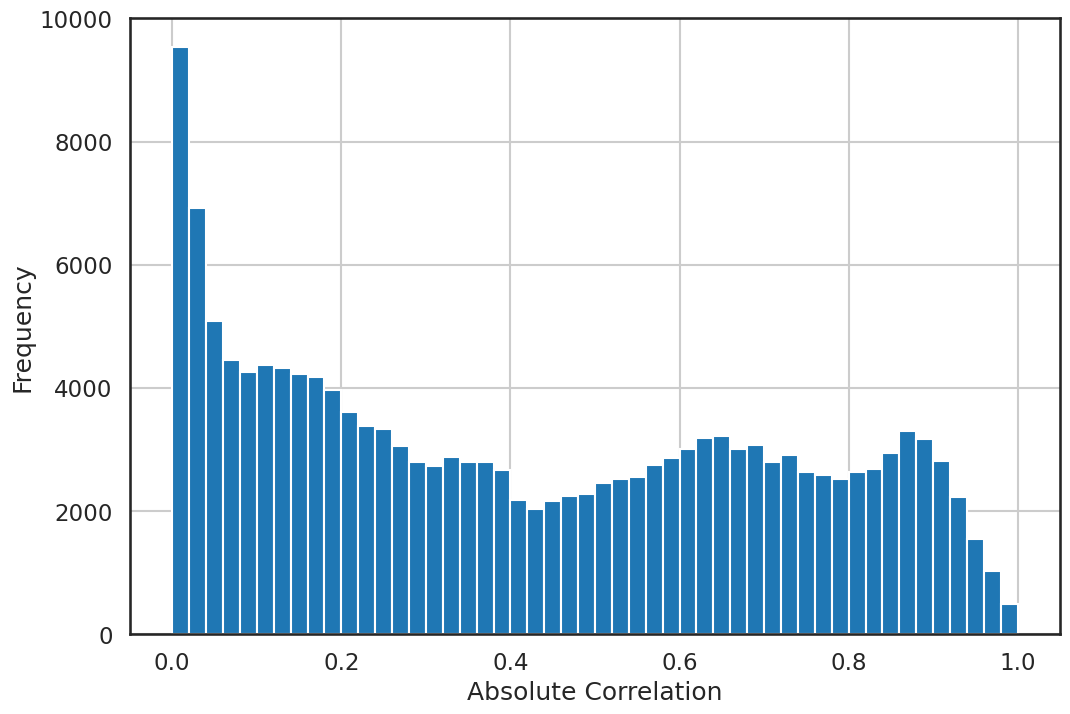

In [13]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [14]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [16]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [18]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [19]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [20]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

## Question 5

* Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 


In [21]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
449  0.014255  0.291515 -0.077923  0.509005 -0.329412 -0.148373 -0.342714   
172  0.008258  0.089467 -0.163937 -0.165171  0.310668 -0.235715  0.080693   
207  0.086239  0.304197 -0.041840 -0.098603  0.069949 -0.896924  0.061838   
545 -0.011598  0.005007  0.244426 -0.183263  0.178947  0.570337  0.048554   
229 -0.056441 -0.052461 -0.154260  0.153947 -0.493036  0.466494  0.000000   
508  0.111711  0.016796  0.040347 -1.081082  0.622517 -0.730937  0.124523   
144  0.048247  0.192315 -0.252876  0.330678  0.033529  0.151371  0.035156   
141 -0.050182 -0.110979 -0.319493 -1.455904  0.140734  1.223384 -0.002922   
34  -0.012545 -0.189669  0.375921  0.089118  0.335763 -0.175083  0.006856   
5    0.003403 -0.281539 -0.085842 -0.001665 -0.397494  0.199328 -0.049463   

                                                             l2            \
            1         2         3         4         5         0         1   
449  0.251392  0.000000  0.979621 -0.488867 -0.245794  0.007610  0.280882   
172  0.000000  0.000000 -0.478863  0.178920 -0.545296  0.015884 -0.680313   
207  0.000000  0.000000  0.000000  0.524871 -2.286570  0.158578  2.230647   
545  0.000000  0.000000  0.000000  0.146723  0.605067 -0.036330 -0.436951   
229  0.000000  0.000000  0.000674 -1.285521  0.320143 -0.100352 -0.053379   
508  0.000000  0.000000 -0.856039  0.477957 -0.775129  0.185232  0.739388   
144  0.000000  0.037043  1.145378 -0.022889 -0.117152  0.130266  0.263876   
141  0.000000  0.000000 -3.714134  0.750551  2.823622 -0.076060 -0.030775   
34   0.000000  0.000000  0.000000  1.757703 -0.149178  0.024824 -1.065432   
5   -0.358438  0.000000  0.000000 -0.350130  0.102793  0.031943 -1.396713   

                                             
            2         3         4         5  
449 -0.112416  1.540917 -0.762642 -0.275285  
172 -0.065420 -0.827957  0.699461 -0.462241  
207 -0.178355  0.001772  0.106943 -1.991246  
545  0.276113 -0.717294  0.294547  1.369856  
229 -0.240204  0.525123 -1.166127  0.623805  
508  0.008503 -2.594600  1.139749 -1.601920  
144 -0.155423  0.476908  0.302702  0.273608  
141 -0.550837 -4.562733  0.622716  2.681878  
34   0.554757  0.071339  0.633436 -0.325740  
5   -0.092852  0.000652 -0.731461  0.335963

Prepare six separate plots for each of the multi-class coefficients.


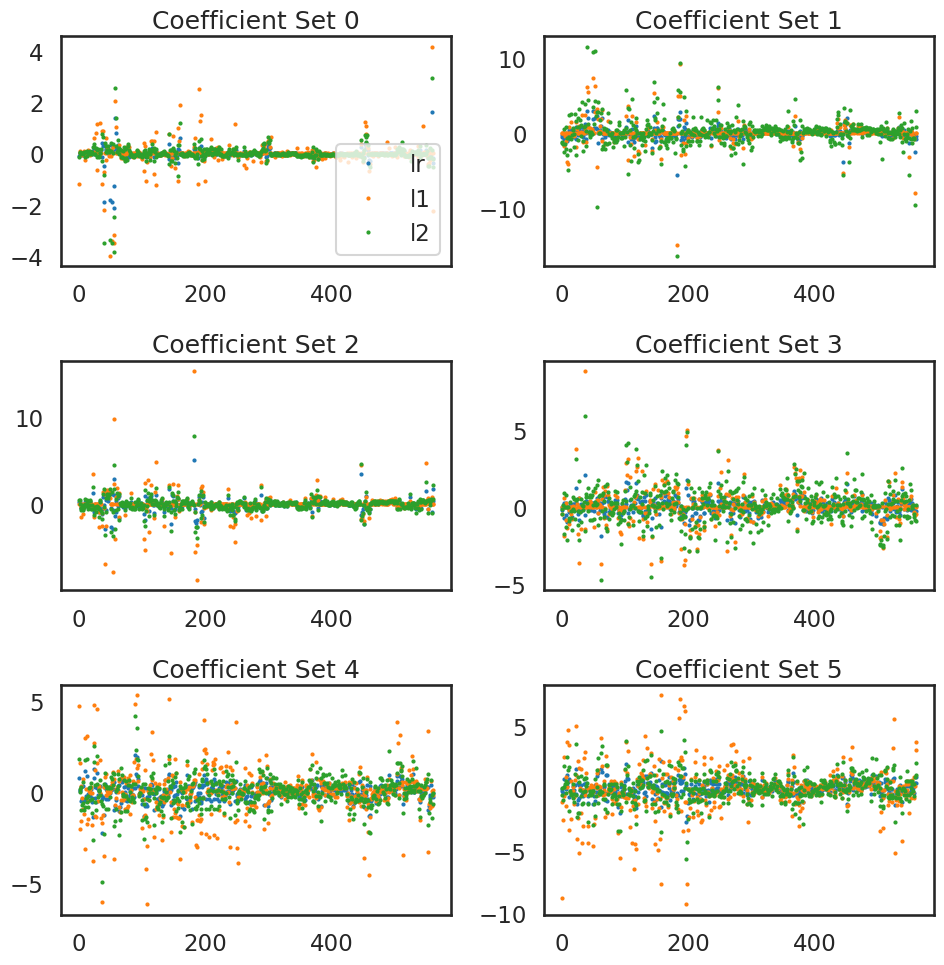

In [22]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 6

* Predict and store the class for each model.
* Store the probability for the predicted class for each model. 


In [23]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [24]:
y_prob.head()

,lr,l1,l2
0,0.998939,0.998931,0.999757
1,0.988125,0.999782,0.999477
2,0.987580,0.995970,0.999671
3,0.981381,0.999168,0.994338
4,0.998280,0.999922,0.999997


## Question 7

For each model, calculate the following error metrics: 

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [25]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [26]:
metrics

,lr,l1,l2
precision,0.984144,0.983835,0.983824
recall,0.984142,0.983819,0.983819
fscore,0.984143,0.983815,0.983819
accuracy,0.984142,0.983819,0.983819
auc,0.990384,0.990144,0.990165


## Question 8

* Display or plot the confusion matrix for each model.


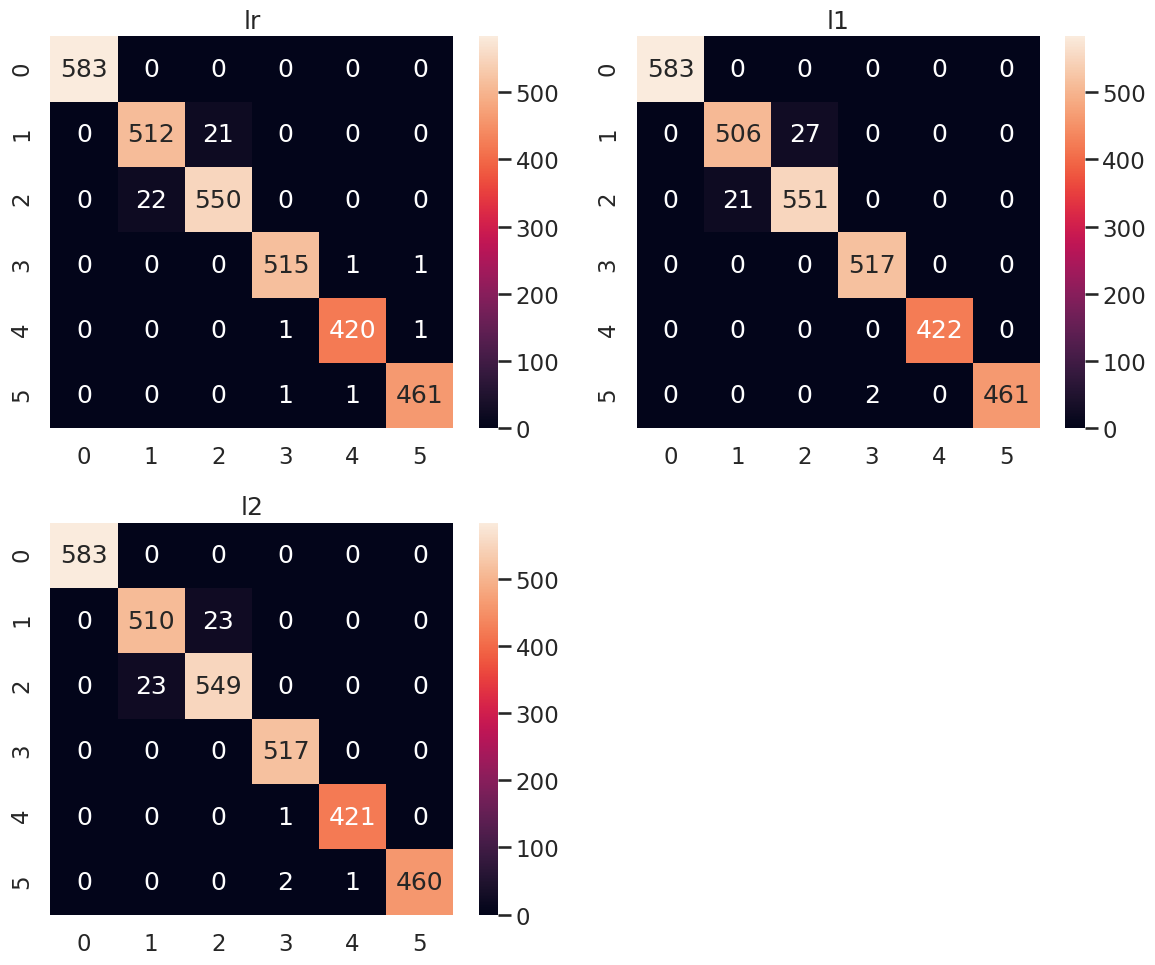

In [27]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

---
### Machine Learning Foundation (C) 2020 IBM Corporation
